In [10]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd


import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '5036'#'8508'
run = 'nref11c_nref9f'#'ludicrous/nref11c_nref9f.enhance'
snap ='RD0042' #'DD2520'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['H I','C II','C III','C IV','O VI']#['Lyalpha', 'Halpha', 'C III','SiII','SiIII','SiIV','MgII']
trident_ions = ['H I','C II','C III','C IV','O VI']
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""

prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
save_path = prefix + f'proj_density_plots/'
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists


# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=trident_ions)
    return ds


In [11]:
import numpy as np
from foggie.utils.consistency import *
from yt.data_objects.level_sets.api import * #TODO - Not super slow here, but replace with custom clump finding to find disk?
import h5py

halo_dict = {   '2392'  :  'Hurricane' ,
                '2878'  :  'Cyclone' ,
                '4123'  :  'Blizzard' ,
                '5016'  :  'Squall' ,
                '5036'  :  'Maelstrom' ,
                '8508'  :  'Tempest',
                '002392'  :  'Hurricane' ,
                '002878'  :  'Cyclone' ,
                '004123'  :  'Blizzard' ,
                '005016'  :  'Squall' ,
                '005036'  :  'Maelstrom' ,
                '008508'  :  'Tempest' }

def halo_id_to_name(halo_id):
    return halo_dict[str(halo_id)]
    
def read_virial_mass_file(halo_id,snapshot,refinement_scheme,codedir,key="radius"):
    '''
    Read in single entries from the virial mass file for a certain key for 1 snapshot
    Keys include: ['redshift', 'snapshot', 'radius', 'total_mass', 'dm_mass', 'stars_mass',
    'young_stars_mass', 'old_stars_mass', 'gas_mass', 'gas_metal_mass', 'gas_H_mass',
    'gas_HI_mass', 'gas_HII_mass', 'gas_CII_mass', 'gas_CIII_mass', 'gas_CIV_mass',
    'gas_OVI_mass', 'gas_OVII_mass', 'gas_MgII_mass', 'gas_SiII_mass', 'gas_SiIII_mass', 
    'gas_SiIV_mass', 'gas_NeVIII_mass']
    '''
    from astropy.table import Table
    masses_dir = codedir+"foggie/halo_infos/"+halo_id+"/"+refinement_scheme+"/rvir_masses.hdf5"
    rvir_masses = Table.read(masses_dir, path='all_data')
    
    return rvir_masses[key][rvir_masses['snapshot']==snapshot][-1]
    
    
def get_cgm_density_cut(ds,cut_type="comoving_density",additional_factor=2.,code_dir=None):
    '''
    Get a density cutoff to separate the galaxy from the CGM
    '''
    if cut_type=="comoving_density":
        z = ds.get_parameter('CosmologyCurrentRedshift')
        cgm_density_cut = 0.1 *additional_factor* cgm_density_max * (1+z)**3
    elif cut_type=="relative_density":
        try: Rvir = read_virial_mass_file(gal_id, "RD0042","nref11c_nref9f",code_dir)
        except:
            print("Warning: Could not read rvir file for this halo...")
            Rvir = 300.
        print("Rvir set to:",Rvir)
        #ds, refine_box = foggie_load(snap_name, trackname, halo_c_v_name=halo_c_v_name, do_filter_particles=True,disk_relative=True,particle_type_for_angmom=particle_type_for_angmom,smooth_AM_name = smooth_AM_name)
        sphere = ds.sphere(center=ds.halo_center_kpc, radius=(Rvir, 'kpc')) 
        z = ds.get_parameter('CosmologyCurrentRedshift')
        mask = ((sphere['gas','radius_corrected']>50./(1+z)) & (sphere['gas','density']<=cgm_density_max*(1+z)**3))
        
        mean_density = np.average( sphere['gas','density'][mask], weights=sphere['cell_volume'][mask])
        stdv_density = np.sqrt( np.average( np.power(sphere['gas','density'][mask] - mean_density , 2) , weights=sphere['cell_volume'][mask]))
        cgm_density_cut = mean_density + additional_factor * stdv_density 
    else:
        # Define the density cut between disk and CGM to vary smoothly between 1 and 0.1 between z = 0.5 and z = 0.25,
        # with it being 1 at higher redshifts and 0.1 at lower redshifts
        # Cassi's original definition
        current_time = ds.current_time.in_units('Myr').v
        if (current_time<=7091.48):
            density_cut_factor = 20. - 19.*current_time/7091.48
        elif (current_time<=8656.88):
            density_cut_factor = 1.
        elif (current_time<=10787.12):
            density_cut_factor = 1. - 0.9*(current_time-8656.88)/2130.24
        else:
            density_cut_factor = 0.1
        
        cgm_density_cut = cgm_density_max * density_cut_factor * additional_factor
        z = ds.get_parameter('CosmologyCurrentRedshift')
        print("Cassi's cut is:",cgm_density_cut,"(comoving would be",0.1*additional_factor*cgm_density_max*(1+z)**3,")")
    return cgm_density_cut







def find_disk(ds,max_disk_radius=100.,use_comoving_density=True,comoving_scaler=0.2):
    cgm_density_cut = get_cgm_density_cut(ds,use_comoving_density,comoving_scaler)


    sphere = ds.sphere(center=ds.halo_center_kpc, radius=(max_disk_radius, 'kpc'))
    sph_ism = sphere.cut_region("obj['density'] > %.3e" % (cgm_density_cut))
    

    #Test to identify just the disk
    master_clump = Clump(sphere, ("gas", "density"))
    master_clump.add_validator("min_cells", 200)
    c_min = sph_ism["gas", "density"].min()
    c_max = sph_ism["gas", "density"].max()
    #Force to only find highest level clumps
    step = c_max / c_min #100. #2.0

    find_clumps(master_clump, c_min, c_max, step)

    leaf_clumps=master_clump.leaves
    #child_clumps=master_clump.children
    current_max=0
    for leaf in leaf_clumps:
        ncells = np.size(leaf["gas","density"])
        if ncells>current_max:
            current_max = ncells
            disk_clump = leaf


    return disk_clump



global clump_cell_ids

def _masked_field(field,data):
    return ~np.isin(data["index","cell_id_2"],clump_cell_ids) #if you want to remove disk
    #return np.isin(data["index","cell_id_2"],clump_cell_ids) #if you only want disk
    

global max_gid
global gx_min; global gy_min; global gz_min
global gx_max; global gy_max; global gz_max

def get_cell_grid_ids(field, data):
    gids = data['index','grid_indices'] + 1 #These are different in yt and enzo...
    u_id = np.copy(gids)
    
    idx_dx = data['index','dx']

    x_id = np.divide(data['index','x'] - idx_dx/2. , idx_dx)
    y_id = np.divide(data['index','y'] - idx_dx/2. , idx_dx)
    z_id = np.divide(data['index','z'] - idx_dx/2. , idx_dx)
    
    
    for gid in np.round(np.unique(gids)).astype(int): 
        if gid<=0: continue
        grid_mask = (gids==gid)
        if np.size(np.where(grid_mask)[0])<=0: continue

        gx = x_id[grid_mask]
        gy = y_id[grid_mask]
        gz = z_id[grid_mask]

        gx = gx - gx_min[gid-1]
        gy = gy - gy_min[gid-1]
        gz = gz - gz_min[gid-1]


        max_x = gx_max[gid-1]-gx_min[gid-1]
        max_y = gy_max[gid-1]-gy_min[gid-1]

        c_id =  gx+gy*(max_x+1) +gz*(max_x+1)*(max_y+1)

        u_id[grid_mask] = np.round(gid + c_id * (max_gid+1)).astype(np.uint64)
    return u_id    
    


def load_disk(ds,clump_file,source_cut=None):
    '''
    Function to load a disk cut region defined by clump_finder.py
    Prior to calling this function, the  cell_grid_ids must be added to the dataset
    
    '''

    global clump_cell_ids
    hf = h5py.File(clump_file,'r')
    clump_cell_ids = np.round(np.array(hf['cell_ids']).astype(np.uint64))
    hf.close()

    global max_gid
    max_gid=-1
    for g,m in ds.all_data().blocks:
        if g.id>max_gid: max_gid=g.id
    
    global gx_min; global gy_min; global gz_min
    global gx_max; global gy_max; global gz_max

    gx_min = np.zeros((max_gid))
    gy_min = np.zeros((max_gid))
    gz_min = np.zeros((max_gid))
    gx_max = np.zeros((max_gid))
    gy_max = np.zeros((max_gid))
    gz_max = np.zeros((max_gid))
    
    for g,m in ds.all_data().blocks:
        g_dx = g['index','dx'].max()

        gx_min[g.id-1] = (g['index','x'].min() - g_dx/2.)  / g_dx
        gy_min[g.id-1] = (g['index','y'].min() - g_dx/2.)  / g_dx
        gz_min[g.id-1] = (g['index','z'].min() - g_dx/2.)  / g_dx

        gx_max[g.id-1] = (g['index','x'].max() - g_dx/2.)  / g_dx
        gy_max[g.id-1] = (g['index','y'].max() - g_dx/2.)  / g_dx
        gz_max[g.id-1] = (g['index','z'].max() - g_dx/2.)  / g_dx 

    ds.add_field(
        ('index', 'cell_id_2'),
          function=get_cell_grid_ids,
          sampling_type='cell',
          force_override=True
    )

    ds.add_field(
        ("index","masked_field"),
        function=_masked_field,
        sampling_type="cell",
        units="",
        force_override=True
    )

    if source_cut is None:
        source_cut = ds.all_data()
    masked_region = source_cut.cut_region(["obj['index','masked_field']"])

    return masked_region



In [12]:
snap_name = foggie_dir + snap + '/' + snap
    
ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)
zsnap = ds.get_parameter('CosmologyCurrentRedshift')
clump_file = output_dir + 'ions_halo_008508/ludicrous/nref11c_nref9f.enhance/Disk/test_Disk.h5'




yt : [INFO     ] 2025-02-06 18:14:09,382 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2025-02-06 18:14:09,382 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-02-06 18:14:09,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-02-06 18:14:09,383 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-02-06 18:14:09,383 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-02-06 18:14:09,383 Parameters: current_redshift          = 0
yt : [INFO     ] 2025-02-06 18:14:09,384 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2025-02-06 18:14:09,384 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2025-02-06 18:14:09,384 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-02-06 18:14:09,384 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_005036/nref11c_nref9f/RD0042/RD0042
get_refine_box: using this location: col1   col2     col3     col4     col5     col6     col7   col8
---- -------- -------- -------- -------- -------- -------- ----
 0.0 0.465138 0.500866 0.499993 0.467138 0.502866 0.501993    9


Parsing Hierarchy : 100%|██████████| 6108/6108 [00:00<00:00, 25425.20it/s]
yt : [INFO     ] 2025-02-06 18:14:09,846 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2025-02-06 18:14:10,119 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-02-06 18:14:10,123 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-02-06 18:14:10,128 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-02-06 18:14:10,132 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-02-06 18:14:10,136 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-02-06 18:14:10,140 The dm particle filter already exists. Overriding.


Pulling halo center from catalog file
filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector


In [6]:
cgm_region = load_disk(ds,clump_file,source_cut=None)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/vidasaeedzadeh/Projects/foggie_outputs/ions_halo_008508/ludicrous/nref11c_nref9f.enhance/Disk/test_Disk.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

yt : [INFO     ] 2025-02-06 18:14:21,464 xlim = -0.000347 0.000347
yt : [INFO     ] 2025-02-06 18:14:21,464 ylim = -0.000347 0.000347
yt : [INFO     ] 2025-02-06 18:14:21,465 zlim = -0.500000 0.500000
yt : [INFO     ] 2025-02-06 18:14:21,465 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2025-02-06 18:14:38,713 Saving plot /Users/vidasaeedzadeh/Projects/foggie_outputs/ions_halo_005036/nref11c_nref9f/proj_density_plots/density_wdisk.png



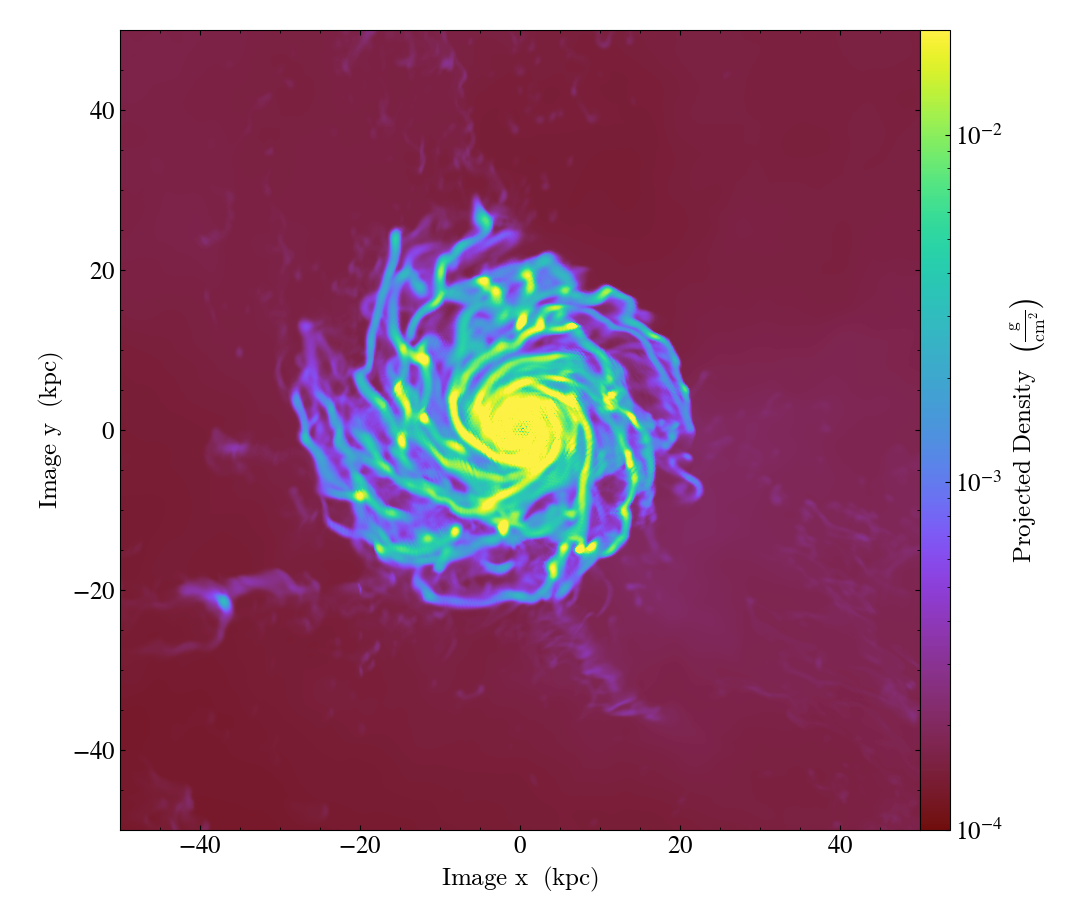

In [13]:
#proj_edge = yt.ProjectionPlot(ds, ds.x_unit_disk, ('gas','Emission_' + ions_dict[ion]), center=ds.halo_center_kpc, width=(ds.refine_width, 'kpc'), north_vector=ds.z_unit_disk)

proj = yt.ProjectionPlot(ds,ds.z_unit_disk,('gas','density'),center=ds.halo_center_kpc,width=(100.,'kpc'))#, north_vector=ds.x_unit_disk)
proj.set_zlim('density', 1e-4, 2e-2)
proj.save(save_path + f'density_wdisk.png')
proj.show()


yt : [INFO     ] 2025-02-06 18:14:38,970 xlim = -0.000347 0.000347
yt : [INFO     ] 2025-02-06 18:14:38,971 ylim = -0.000347 0.000347
yt : [INFO     ] 2025-02-06 18:14:38,971 zlim = -0.500000 0.500000
yt : [INFO     ] 2025-02-06 18:14:38,971 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2025-02-06 18:14:56,006 Saving plot /Users/vidasaeedzadeh/Projects/foggie_outputs/ions_halo_005036/nref11c_nref9f/proj_density_plots/density_wdisk.png



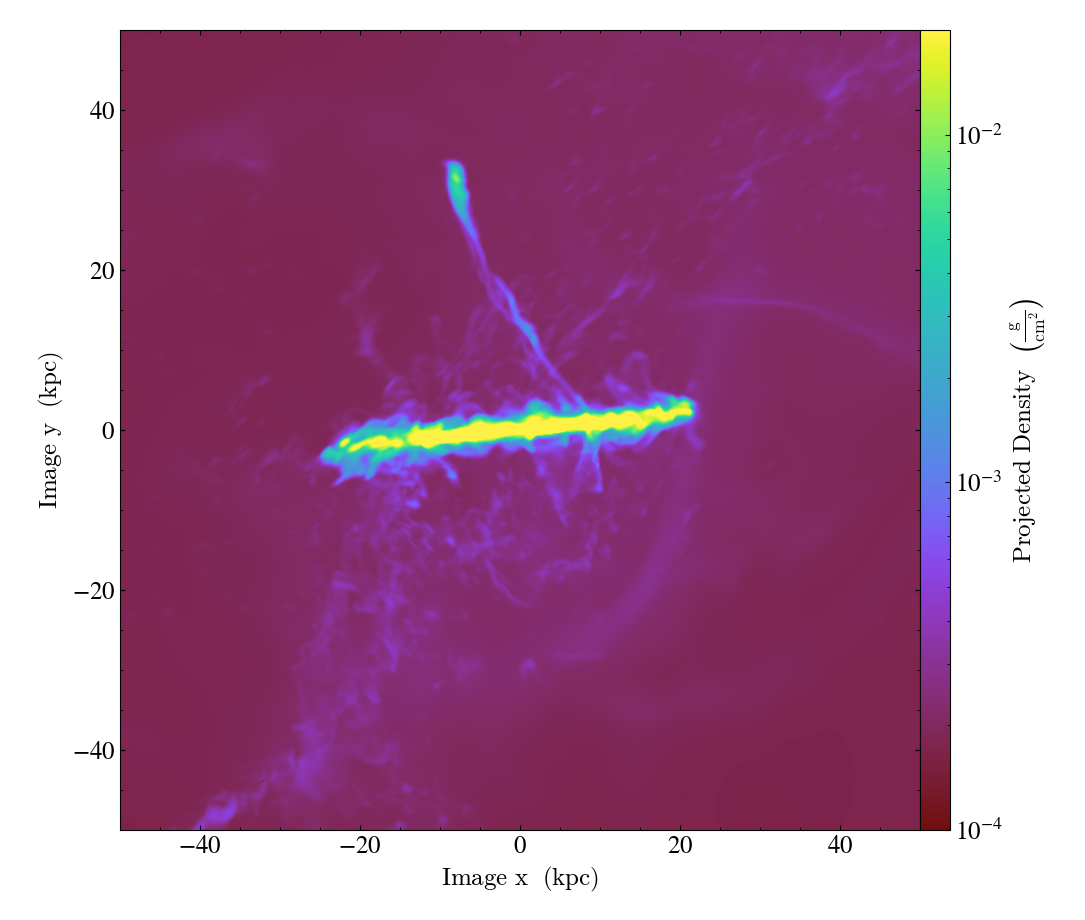

In [14]:
proj = yt.ProjectionPlot(ds,ds.x_unit_disk,('gas','density'),center=ds.halo_center_kpc,width=(100.,'kpc'))#, north_vector=ds.z_unit_disk)
proj.set_zlim('density', 1e-4, 2e-2)
proj.save(save_path + f'density_wdisk.png')
proj.show()

In [ ]:
proj = yt.ProjectionPlot(ds,ds.x_unit_disk,('gas','vx_corrected'),center=ds.halo_center_kpc,width=(100.,'kpc'),weight_field=('gas','mass'))#, north_vector=ds.z_unit_disk)
#proj.set_zlim('density', 1e-4, 2e-2)
#proj.save(save_path + f'density_wdisk.png')
proj.show()

YTFieldNotFound: Could not find field ('gas', 'vr_corrected') in RD0042.
Did you mean:
	('gas', 'vx_corrected')
	('gas', 'vy_corrected')
	('gas', 'vz_corrected')

yt : [INFO     ] 2025-01-28 10:06:03,063 xlim = -0.000695 0.000695
yt : [INFO     ] 2025-01-28 10:06:03,064 ylim = -0.000695 0.000695
yt : [INFO     ] 2025-01-28 10:06:03,064 zlim = -0.500000 0.500000
yt : [INFO     ] 2025-01-28 10:06:03,065 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [WARNING  ] 2025-01-28 10:06:03,519 Field ('index', 'cell_id_2') was added without specifying units or dimensions, auto setting units to 'dimensionless'
yt : [INFO     ] 2025-01-28 10:06:54,981 Saving plot /Users/vidasaeedzadeh/Projects/foggie_outputs/ions_halo_008508/ludicrous/nref11c_nref9f.enhance/proj_density_plots/density_wodisk.png



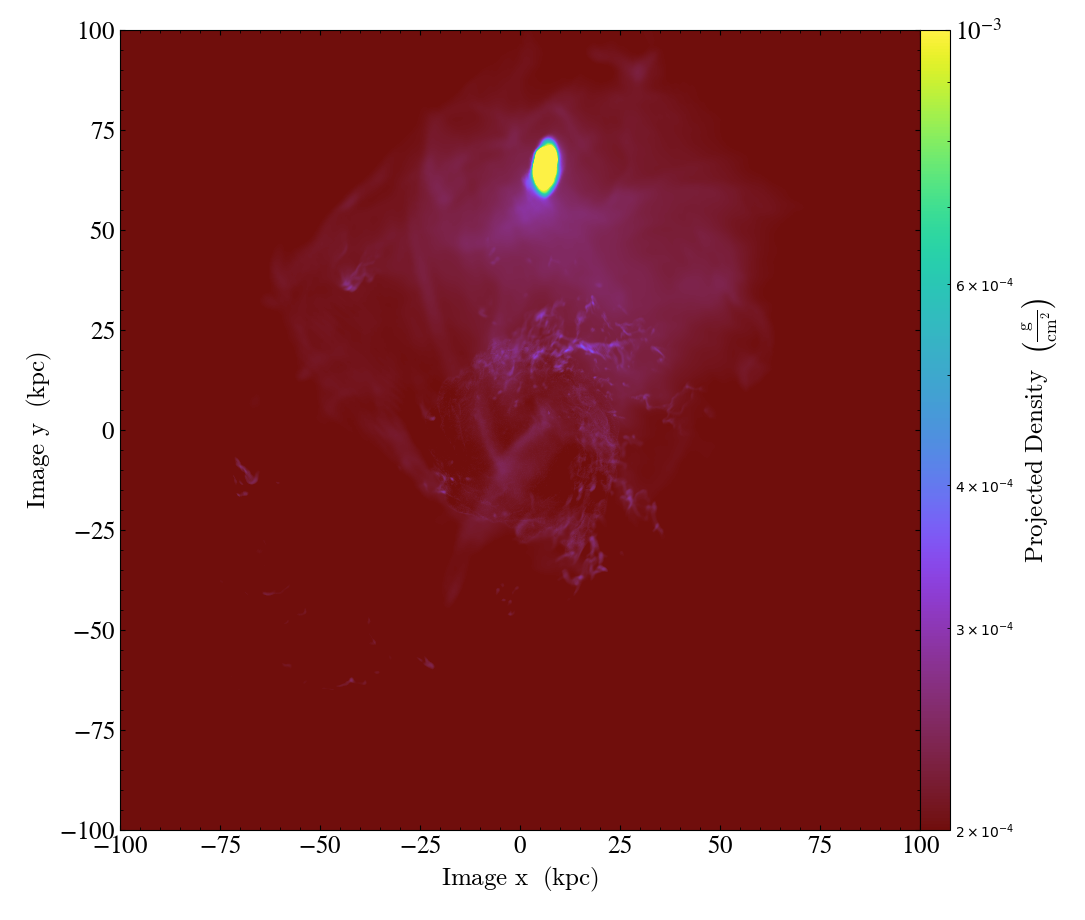

In [6]:
#proj = yt.ProjectionPlot(ds,'z','density',center=ds.halo_center_kpc,width=(200.,'kpc'),data_source = cgm_region)
proj = yt.ProjectionPlot(ds,ds.z_unit_disk,('gas','density'),center=ds.halo_center_kpc,width=(200.,'kpc'), north_vector=ds.x_unit_disk,data_source = cgm_region)
proj.set_zlim('density', 2e-4, 1e-3)
proj.save(save_path + f'density_wodisk.png')
proj.show()
